Pretty front-end for the simulation and the run-result's analysis.

Imports the functions from the source-files and persists the outputs for easier perusing.

In [1]:
# We want to reload all modules before execution, each time, as we do not care about performance
# but easy development and we will be changing the modules a ton:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from strategy_simulation import Simulation, SimulationOptions

In [3]:
sim = Simulation(path="prices", options=SimulationOptions())

Loaded 216 stocks from prices.
54 stocks were rejected for reason of having less than 5000 entries.
After filtering out 0 rows with weird date formats, 10367 rows remain.
After removal of discontinuous stock price lists was skipped, 162 stocks are left.



## Analyse the missing fields in the prices

In [4]:
is_na_df = sim.prices.isna()
is_na_matrix = is_na_df.values

In [5]:
# Find the number of status switches for each stock, where a status switch is when data becomes available 
# or ceases to be available:
status_switch = is_na_matrix[1:, :] != is_na_matrix[:-1, :]

In [6]:
# Stock-wise number of status switches over the history:
status_switch.sum(axis=0)

array([30, 31, 31, 31, 31, 31, 13, 31, 13, 31, 31, 31, 31, 31, 31, 31, 13,
       30, 30, 30, 31, 31, 31, 31, 31, 30, 31, 31, 31, 30, 31, 31, 31, 31,
       31, 30, 31, 31, 31, 13, 13, 31, 31, 31, 31, 31, 33, 31, 13, 31, 31,
       31, 31, 30, 31, 31, 13, 31, 31, 31, 31, 17, 13, 31, 30, 30, 13, 31,
       31, 31, 31, 31, 31, 30, 31, 30, 13, 31, 31, 31, 30, 31, 31, 31, 21,
       31, 30, 30, 31, 30, 30, 23, 31, 31, 31, 30, 30, 13, 31, 30, 31, 31,
       31, 30, 25, 19, 30, 29, 19, 31, 31, 31, 30, 13, 13, 31, 31, 31, 30,
       31, 30, 17, 31, 30, 30, 31, 31, 13, 31, 31, 19, 13, 17, 31, 30, 30,
       30, 31, 31, 30, 30, 17, 31, 31, 31, 31, 13, 31, 31, 30, 31, 31, 31,
       31, 30, 30, 30, 31, 30, 31, 13, 13])

**Learning**: There is a fairly consistent number of switches, which seems to indicate that the data has a common pattern of availability.

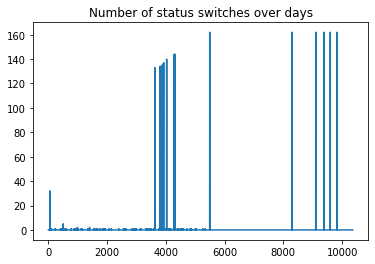

In [7]:
plt.plot(status_switch.sum(axis=1))
plt.title('Number of status switches over days')
plt.show()

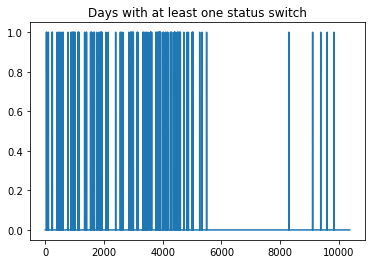

In [8]:
plt.plot(status_switch.sum(axis=1) > 0)
plt.title('Days with at least one status switch')
plt.show()

[]

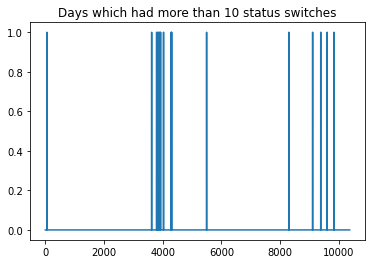

In [9]:
plt.plot(status_switch.sum(axis=1) > 10)
plt.title('Days which had more than 10 status switches')
plt.plot()

[]

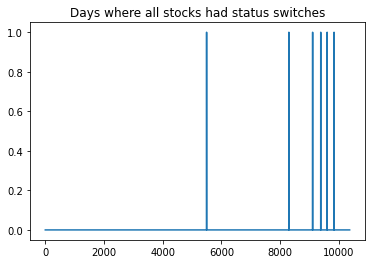

In [10]:
plt.plot(status_switch.sum(axis=1) == len(sim.prices.columns))
plt.title('Days where all stocks had status switches')
plt.plot()

**Learning**: Since about 2003 (index 6000'ish), there were fewer status switches, but if there some, they affect all stocks. Seems to be the missing data is training pauses.

In [11]:
# At which days did the training stops after happen?
sim.prices.index[6001:][status_switch[6000:, :].sum(axis=1) == len(sim.prices.columns)]

Index(['2012-10-29', '2012-10-31', '2016-01-18', '2016-01-19', '2017-02-20',
       '2017-02-21', '2018-01-01', '2018-01-02', '2018-12-05', '2018-12-06'],
      dtype='object', name='Date')

In [12]:
# We can now go through each stock in line and pairwise compare the indices of status switches.
# This should give us an idea of the length of the stopped data.
stock_missing_data_lengths = {}
for k, stock in enumerate(sim.prices):
    stock_starts_with_nan = np.isnan(sim.prices[stock].iloc[0])
    
    # Get the switching dates and convert them to datetime (two lines, for readability ;) ):
    switching_dates = sim.prices.index[1:][status_switch[:, k]].values
    switching_dates = np.asarray([np.datetime64(d) for d in switching_dates])
    
    # Compare the date-pairs:
    date_differences = [
        ((switching_dates[k + 1] - switching_dates[k]) / np.timedelta64(1, 'D')).astype(int) 
        for k in range(int(stock_starts_with_nan), len(switching_dates) - 1 + int(stock_starts_with_nan), 2)
    ]

    stock_missing_data_lengths[stock] = date_differences

In [13]:
stock_missing_data_lengths

{'CMI_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'VNO_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'TMO_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'CMCSA_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'AMD_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'NEM_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'TPR_prices': [5, 2, 1, 1, 1, 1],
 'BF-B_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'BLK_prices': [5, 2, 1, 1, 1, 1],
 'DUK_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'ZBRA_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'D_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'TSN_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'TJX_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'CERN_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'CINF_prices': [1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1],
 'AEE_prices': [5, 2, 1, 1, 1, 1],
 'WDC_prices': [1, 1, 1